# 2D Poisson's ratio deterministic adjoint-based inversion: role of data noise

This notebook contains several deterministic adjoint-based inversion of the surface geodetic data for the heterogeneous Poisson's ratio structure, assuming the knowledge of the fault slip distribution, as a function of the data noise level.


In [35]:
# Import libraries 
import dolfin as dl
import ufl
import pandas as pd
import math
import numpy as np
# Import libraries for plotting
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.patches import Polygon, Rectangle
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif', size=16)
rc('legend', fontsize=16)
TINY_SIZE = 14
SMALL_SIZE = 20
MEDIUM_SIZE = 30
BIGGER_SIZE = 40
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

import sys, os
#sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "...") )
import hippylib as hp
# Load TV regularization class and observation operator
from pointwiseStateObs import PointwiseStateObservation
from TVprior import *

# Make results reproducible
np.random.seed(seed=1)

# Set parameters compiler
dl.parameters["form_compiler"]["quadrature_degree"] = 5
dl.parameters["form_compiler"]["optimize"] = True
# Mute FFC and UFL warnings
import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)


In [2]:
# Define functions
# Define the compliance matrix for elasticity
def AEsigma(s, mu, nu):
    A = 1./(2.*mu)*( s - nu/( 1 + nu*(dim-2) )*ufl.tr(s)*ufl.Identity(dim) )
    return A

# Define the asymmetry operator
def asym(s): 
    as_ = s[0,1] - s[1,0]
    return as_

# Define the tangent operator
def T(n):
    T_operator = ufl.as_vector( [n[1], -n[0]] )
    return T_operator

# Class to define different properties in the subdomains with anomaly built-in
class K_Triangle(dl.UserExpression):
    def __init__(self, subdomains, k_0, k_1, **kwargs):
        super().__init__(**kwargs)
        self.subdomains = subdomains
        self.k_0 = k_0
        self.k_1 = k_1

    def eval_cell(self, values, x, cell):
        if self.subdomains[cell.index] == triangle_surface:
            values[0] = self.k_0
        else:
            values[0] = self.k_1

    def value_shape(self):
        return ()
        

In [3]:
# Mesh
meshpath = "../mesh/"
name = "Mesh_CurvedFault_Triangle_PaperII"
mesh = dl.Mesh(meshpath + name + '.xml')
xmin = -700.; xmax = 400.; ymin = -500.; ymax = 0.
# Extract dimension of the mesh
dim = mesh.topology().dim()
# Define normal component to boundaries
n = dl.FacetNormal(mesh)
# Define boundaries
boundaries = dl.MeshFunction("size_t", mesh, meshpath + name + '_facet_region.xml')
subdomains = dl.MeshFunction("size_t", mesh, meshpath + name + '_physical_region.xml')
top = 1
left = 2
bottom = 3
right = 4
fault = 5
blockleft = 7
blockright = 8
triangle = 9
triangle_surface = 10
ds = dl.Measure('ds')(domain=mesh, subdomain_data=boundaries)
dS = dl.Measure('dS')(domain=mesh, subdomain_data=boundaries)

# Define sep
sep = "\n"+"#"*80+"\n"


In [4]:
# Create function to interpolate in a region of interest (small portion of the domain)
def get_dx_for_error_evaluation(mesh, xmin, xmax, ymin, ymax):
    class LimitedDomain(dl.SubDomain):
        def inside(self, x, on_boundary):
            x_range = dl.between(x[0], (xmin, xmax))
            y_range = dl.between(x[1], (ymin, ymax))
            return x_range and y_range
    
    # Marker the subdomain
    marker_errors = dl.MeshFunction("size_t", mesh, dim)
    aroundFaultEdges = LimitedDomain()
    marker_errors.set_all(20)
    aroundFaultEdges.mark(marker_errors, 21)
    my_dx = dl.Measure("dx", domain=mesh, subdomain_data=marker_errors)
    
    return my_dx(21)
    

In [5]:
# The linear coseismic inversion problem
# Define the weak formulation of the FORWARD problem
def pde_varf(u, m, p):
    # Split the STATE and ADJOINT variables. Use dl.split() and not
    # .split(deepcopy=True), since the latter breaks FEniCS symbolic differentiation
    sigma, uu, r = dl.split(u)
    tau, w, q = dl.split(p)
    u0 = dl.Constant((0., 0.))
    # Define the weak formulation of the forward problem
    nu_expr = 0.25*(1. + ufl.tanh(m))
    J = ufl.inner( AEsigma(sigma, mu, nu_expr), tau )*ufl.dx \
        + ufl.inner( ufl.div(tau), uu )*ufl.dx \
        + ufl.inner( asym(tau), r )*ufl.dx \
        + ufl.inner( ufl.div(sigma), w )*ufl.dx + ufl.inner( asym(sigma), q )*ufl.dx \
        + ufl.inner( f, w )*dl.dx \
        - ufl.inner( u0, tau*n )*ds(bottom) \
        - ufl.inner( ufl.avg(slip), ufl.dot(  T(n('+')), tau('+')*n('+') ) )*dS(fault)
    return J
    

In [6]:
# Create a function that solve the Poisson's ratio deterministic adjoint-based inversion
def solveInverseProblem(k, targets, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps, verbose=True):
    
    # Define function spaces
    # Use VectorFunctionSpace if the unknown is a vector field.
    # Use FunctionSpace object for scalar fields.
    BDM = dl.VectorFunctionSpace(mesh, "BDM", k)    # stress (tensor field, since BDM is a vector field)
    DGv = dl.VectorFunctionSpace(mesh, "DG", k-1)   # displacement (vector field)
    DGr = dl.FunctionSpace(mesh, "DG", k-1)         # rotation (scalar field)
    ME_element = dl.MixedElement([BDM.ufl_element(), DGv.ufl_element(), DGr.ufl_element()])
    Vu = dl.FunctionSpace(mesh, ME_element)
    n = dl.FacetNormal(mesh)
    # Define function space for the model parameter (scalar), which is continuous
    Vm = dl.FunctionSpace(mesh, "CG", 1)
    # Combine the STATE, PARAMETER and ADJOINT function spaces
    Vh = [Vu, Vm, Vu]
    # Print the dofs of STATE, PARAMETER and ADJOINT variables
    ndofs = [ Vh[hp.STATE].dim(), Vh[hp.PARAMETER].dim(), Vh[hp.ADJOINT].dim() ]
    ndofs_state = [ Vu.sub(0).dim(), Vu.sub(1).dim(), Vu.sub(2).dim() ]
    if verbose:
        print( sep, "Set up the mesh and finite element spaces", sep )
        print( "Number of dofs: STATE={0}, PARAMETER={1}, ADJOINT={2}".format(*ndofs) )
        print( "Number of STATE and ADJOINT dofs: STRESS={0}, DISPLACEMENT={1}, ROTATION={2}".format(*ndofs_state) )

    # Define the STATE and ADJOINT Dirichlet BCs
    zero_tensor = dl.Expression( (("0.", "0."), ("0.", "0.")), degree=5 )
    bc = dl.DirichletBC(Vh[hp.STATE].sub(0), zero_tensor, boundaries, top)
    bc0 = dl.DirichletBC(Vh[hp.STATE].sub(0), zero_tensor, boundaries, top)

    # Define the PDE problem
    pde = hp.PDEVariationalProblem(Vh, pde_varf, bc, bc0, is_fwd_linear=True)

    # Print the number of observations (observed surface horizontal and vertical displacements)
    if verbose:
        print( "Number of observation points: {0}".format(targets.shape[0]) )
    # Define the Misfit function to calculate the data misfit
    misfit = PointwiseStateObservation(Vh[hp.STATE], targets, indicator_vec=dl.interpolate(dl.Constant((0,0,0,0,1,1,0)), Vh[hp.STATE]).vector())
    # Define the regularization component
    reg_handler = vectorTVH1L2handler(gamma_val_TV, gamma_val_H1, delta_val_L2, eps=eps)
    reg = NonGaussian_Prior(Vh[hp.PARAMETER], reg_handler)
    
    # Define the true model PARAMETER
    mtrue = dl.interpolate(mtrue_expr, Vh[hp.PARAMETER]).vector()
    # Define the starting model (initial guess) 'm_0'
    m0 = dl.interpolate(m0_expr, Vh[hp.PARAMETER]).vector()

    # Solve FORWARD problem for the STATE variables & generate synthetic observations
    utrue = pde.generate_state() # all dofs STATE variables and PETSC vector (not FEniCS Function)
    x = [utrue, mtrue, None]
    pde.solveFwd(x[hp.STATE], x)
    # Generate true observations by using the observation operator 'B'
    misfit.B.mult(x[hp.STATE], misfit.d)
        
    # Pollute true observations with random noise and generate synthetic data
    MAX = misfit.d.norm("linf") 
    hp.Random().normal_perturb(noise_std_dev, misfit.d) # Comment if no data noise
    misfit.noise_variance = noise_std_dev*noise_std_dev
    print( "The MAX displacement (m) is: %.4f and standard deviation of the noise (m) is: %.6f" %(MAX, noise_std_dev) )
    print( "Noise variance = {0}".format(noise_std_dev*noise_std_dev) )

    # Extract x,y coordinates of the fault for plotting
    bc1 = dl.DirichletBC(Vm, 10, boundaries, fault)
    um = dl.Function(Vm)
    bc1.apply(um.vector())
    # Extract x,y coordinates of the fault and values
    xslip = dl.interpolate(dl.Expression("x[0]", degree=5), Vm)
    yslip = dl.interpolate(dl.Expression("x[1]", degree=5), Vm)
    xf = xslip.vector()[um.vector() == 10] # x coordinate fault
    yf = yslip.vector()[um.vector() == 10] # y coordinate fault
    # Sort the values
    idx = np.argsort(xf)
    xf = xf[idx]; yf = yf[idx]
    
    # Construct the "Model" --> objective function
    model = hp.Model(pde, reg, misfit)

    if verbose:
        print( sep, "Solve the deterministic inverse problem", sep)
    m = reg.mean.copy()
    parameters = hp.ReducedSpaceNewtonCG_ParameterList()
    parameters["rel_tolerance"] = 1e-12 
    parameters["abs_tolerance"] = 1e-9  
    parameters["max_iter"]      = 100
    parameters["globalization"] = "LS"
    parameters["LS"]["c_armijo"] = 1e-4
    parameters["GN_iter"] = 5
    if verbose == False:
        parameters["print_level"] = -1

    if verbose:
        parameters.showMe()
    solver = hp.ReducedSpaceNewtonCG(model, parameters)
    # Create a vector containig the solution of the inverse problem (MAP point)
    x = solver.solve([None, m, None])
    # Print solver convergence
    if verbose:
        if solver.converged:
            print( "\nConverged in ", solver.it, " iterations.")
        else:
            print( "\nNot Converged")

        print ("Termination reason: ", solver.termination_reasons[solver.reason])
        print ("Final gradient norm: ", solver.final_grad_norm)
        print ("Final cost: ", solver.final_cost)

    # Convert from m to Poisson's ratio
    mtrue_fun = hp.vector2Function(mtrue, Vh[hp.PARAMETER])
    poisson_true = dl.project(dl.Constant(0.25)*(dl.Constant(1.) + ufl.tanh(mtrue_fun)), Vh[hp.PARAMETER] )
    m_fun = hp.vector2Function(m, Vh[hp.PARAMETER])
    poisson = dl.project(dl.Constant(0.25)*(dl.Constant(1.) + ufl.tanh(m_fun)), Vh[hp.PARAMETER] )
    # Print the range of the MAP point
    if verbose:
        print( min(poisson.vector()[:]), max(poisson.vector()[:]) )

    # Calculate relative error in the domain
    lef, rig, bot, topp = -200., 100., -150., 0.
    my_dx = get_dx_for_error_evaluation(mesh, lef, rig, bot, topp)
    # Absolute L1-norm
    #rel_error = dl.assemble( abs(poisson_true-poisson)*my_dx ) 
    # Relative L2-norm
    rel_error = dl.sqrt( dl.assemble( dl.inner(poisson_true-poisson, poisson_true-poisson)*my_dx ) / dl.assemble( dl.inner(poisson_true, poisson_true)*my_dx ) ) * 100
    if verbose:
        print( "The relative error is: %.1f per cent" %rel_error )
        
        
    # Look spectum Hessian misfit generalized eigenproblem
    model.setPointForHessianEvaluations(x, gauss_newton_approx=False)
    Hmisfit = hp.ReducedHessian(model, misfit_only=True)
    k_evec = 80
    p_evec = 20
    if verbose:
        print( "Single/Double Pass Algorithm. Requested eigenvectors: {0}; Oversampling {1}".format(k_evec, p_evec) )
    Omega = hp.MultiVector(x[hp.PARAMETER], k_evec+p_evec)
    hp.Random().normal(1., Omega)
    # Consider also the mass matrix for the generalized eigenproblem
    trial = dl.TrialFunction(Vh[hp.PARAMETER])
    test = dl.TestFunction(Vh[hp.PARAMETER])
    Mvarf = ufl.inner(trial, test)*ufl.dx
    M = dl.assemble(Mvarf, keep_diagonal=True)
    M.ident_zeros()
    M_solver = hp.PETScKrylovSolver(Vh[hp.PARAMETER].mesh().mpi_comm(), "cg", "jacobi")
    M_solver.set_operator(M) # reg.Msolver
    # Solve the eigenvalue problem: H_misfit v = lambda M_i v
    #lmbda, V = hp.doublePassG(Hmisfit, M, M_solver, Omega, k_evec)
    #lmbda, V = hp.doublePass(Hmisfit, Omega, k_evec, s=1)
    lmbda, V = hp.doublePassG(Hmisfit, reg.R, reg.Rsolver, Omega, k_evec)
    
    # Calculate EIG
    posterior = hp.GaussianLRPosterior(reg, lmbda, V)
    posterior.mean = x[hp.PARAMETER]
    kl_dist = posterior.klDistanceFromPrior()
    if verbose:
        print ("KL-Distance from prior: ", kl_dist)
    
        
    return( mesh, Vh, targets, xf, yf, utrue, poisson_true, poisson, rel_error, lmbda, noise_std_dev, kl_dist )
    

In [7]:
### DEFINE COMMON PARAMETERS ###
# Define order of elements (k = 1 --> linear; k = 2 --> quadratic)
k = 1
# Define body force
f = dl.Constant((0., 0.))
# Define the true model PARAMETER
mu = 30e9         # Young's modulus
nu_b = -0.2       # background Poisson's ratio
nu_background = 0.25*(1.+np.tanh(nu_b))
nu_i = 0.425      # anomaly Poisson's ratio
nu_anomaly = 0.25*(1.+np.tanh(nu_i))
print( "The Poisson's ratio for the anomaly is: nu = %.2f while the background nu = %.2f" %(nu_anomaly, nu_background) )
mtrue_expr = K_Triangle(subdomains, nu_i, nu_b, degree=0)
# Define the expression for starting model
m0_expr = dl.Constant(0.)
slip = dl.Expression(('u0*exp(-(pow((x[1]-xc),2)/(pow(std,2))))'), u0=-10., xc=-20., std=15., degree=5)


The Poisson's ratio for the anomaly is: nu = 0.35 while the background nu = 0.20


In [8]:
# Define the axes range
lef, rig, topp, bot = -200., 100., 0., -150.

# Define colormaps and level for contourf
cmap_1 = plt.get_cmap("Blues")
cmap_2 = plt.get_cmap("viridis", 21)
cmap_3 = plt.get_cmap("RdBu_r")
cmap_4 = plt.get_cmap("RdBu_r", 21)
levels_ux = np.linspace(-0.5, 0.5, 21)
levels_uy = np.linspace(-0.5, 0.5, 21)
levels_m = np.linspace(nu_background-1e-5, nu_anomaly+1e-3, 21)
colors = [ cmap_1(0.3), cmap_1(0.6), cmap_1(0.9) ]

# Create the perimeter of the triangular anomaly
xy_triangle = np.array([ [-160.0,-5.0], [-30.0,-5.0], [-95.0, -55.0] ]) 

# For labels of subplots (a,b,c,d)
props = dict(boxstyle='round', lw=0.25, facecolor='ivory', alpha=0.95)
props1 = dict(boxstyle='round', facecolor=cmap_1(0.01), edgecolor=cmap_1(0.01), alpha=1.)


In [9]:
# Generate random surface observations
ntargets = 20
targets_x = np.linspace(-180., 0., ntargets) 
targets_y = (ymax-dl.DOLFIN_EPS)*np.ones(ntargets)
targets = np.zeros([ntargets, dim])
targets[:,0] = targets_x; targets[:,1] = targets_y


In [10]:
# Choose data noise
noise_std_dev = 1e-9

# Define regularization weights
eps = 1e-12 
gamma_val_TV = 1e-7 
gamma_val_H1 = 0.0
delta_val_L2 = 1e-16 

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue, mtrue, m_1, rel_error_1, lmbda_1, noise_std_dev_1, kl_dist_1 ) = solveInverseProblem(k, targets, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 2.6328 and standard deviation of the noise (m) is: 0.000000
Noise variance = 1e-18

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (0.0001): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtracking i

/Users/simo/src/hippylib/hippylib/modeling/posterior.py:71: RuntimeWarning: invalid value encountered in power
  self.d = ones - np.power(ones + d, -.5)
/Users/simo/src/hippylib/hippylib/modeling/posterior.py:215: RuntimeWarning: invalid value encountered in log
  c_logdet = 0.5*np.sum( np.log(dplus1) )


In [11]:
# Choose data noise
noise_std_dev = 0.002

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1 
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3 

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue, mtrue, m_2, rel_error_2, lmbda_2, noise_std_dev_2, kl_dist_2 ) = solveInverseProblem(k, targets, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 2.6328 and standard deviation of the noise (m) is: 0.002000
Noise variance = 4e-06

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (0.0001): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtracking i

In [12]:
# Choose data noise
noise_std_dev = 0.015

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1 
gamma_val_H1 = 0.0 
delta_val_L2 = 1e-3 

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue, mtrue, m_3, rel_error_3, lmbda_3, noise_std_dev_3, kl_dist_3 ) = solveInverseProblem(k, targets, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 2.6328 and standard deviation of the noise (m) is: 0.015000
Noise variance = 0.000225

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (0.0001): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtrackin

In [13]:
# Choose data noise
noise_std_dev = 0.01

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1 
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3 

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue, mtrue, m_4, rel_error_4, lmbda_4, noise_std_dev_4, kl_dist_4 ) = solveInverseProblem(k, targets, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 2.6328 and standard deviation of the noise (m) is: 0.010000
Noise variance = 0.0001

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (0.0001): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtracking 

In [14]:
# Choose data noise
noise_std_dev = 0.005

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3 

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue, mtrue, m_5, rel_error_5, lmbda_5, noise_std_dev_5, kl_dist_5 ) = solveInverseProblem(k, targets, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 2.6328 and standard deviation of the noise (m) is: 0.005000
Noise variance = 2.5e-05

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (0.0001): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtracking

In [15]:
# Choose data noise
noise_std_dev = 0.0035

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1 
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3

m0_expr = dl.Constant(0.)

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue, mtrue, m_6, rel_error_6, lmbda_6, noise_std_dev_6, kl_dist_6 ) = solveInverseProblem(k, targets, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 2.6328 and standard deviation of the noise (m) is: 0.003500
Noise variance = 1.2250000000000001e-05

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (0.0001): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number 

In [16]:
# Choose data noise
noise_std_dev = 0.008

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1  
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3

m0_expr = dl.Constant(0.)

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue, mtrue, m_7, rel_error_7, lmbda_7, noise_std_dev_7, kl_dist_7 ) = solveInverseProblem(k, targets, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 2.6328 and standard deviation of the noise (m) is: 0.008000
Noise variance = 6.4e-05

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (0.0001): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtracking

In [17]:
# Choose data noise
noise_std_dev = 0.0065

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1  
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3

m0_expr = dl.Constant(0.)

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue, mtrue, m_8, rel_error_8, lmbda_8, noise_std_dev_8, kl_dist_8 ) = solveInverseProblem(k, targets, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 2.6328 and standard deviation of the noise (m) is: 0.006500
Noise variance = 4.225e-05

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (0.0001): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtracki

In [18]:
# Choose data noise
noise_std_dev = 0.012

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1 
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3

m0_expr = dl.Constant(0.)

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue, mtrue, m_9, rel_error_9, lmbda_9, noise_std_dev_9, kl_dist_9 ) = solveInverseProblem(k, targets, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 2.6328 and standard deviation of the noise (m) is: 0.012000
Noise variance = 0.000144

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (0.0001): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtrackin

In [19]:
# Choose data noise
noise_std_dev = 0.00275

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1 
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3

m0_expr = dl.Constant(0.)

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue, mtrue, m_10, rel_error_10, lmbda_10, noise_std_dev_10, kl_dist_10 ) = solveInverseProblem(k, targets, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 2.6328 and standard deviation of the noise (m) is: 0.002750
Noise variance = 7.562499999999999e-06

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (0.0001): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number o

In [20]:
# Choose data noise
noise_std_dev = 0.0022

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1  
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3

m0_expr = dl.Constant(0.)

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue, mtrue, m_11, rel_error_11, lmbda_11, noise_std_dev_11, kl_dist_11 ) = solveInverseProblem(k, targets, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 2.6328 and standard deviation of the noise (m) is: 0.002200
Noise variance = 4.84e-06

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (0.0001): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtrackin

In [21]:
# Choose data noise
noise_std_dev = 0.03

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1 
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3

m0_expr = dl.Constant(0.)

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue, mtrue, m_12, rel_error_12, lmbda_12, noise_std_dev_12, kl_dist_12 ) = solveInverseProblem(k, targets, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 2.6328 and standard deviation of the noise (m) is: 0.030000
Noise variance = 0.0009

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (0.0001): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtracking 

In [22]:
# Choose data noise
noise_std_dev = 0.05

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1  
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3

m0_expr = dl.Constant(0.)

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue, mtrue, m_13, rel_error_13, lmbda_13, noise_std_dev_13, kl_dist_13 ) = solveInverseProblem(k, targets, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 2.6328 and standard deviation of the noise (m) is: 0.050000
Noise variance = 0.0025000000000000005

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (0.0001): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number o

In [23]:
# Choose data noise
noise_std_dev = 0.1

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1 
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3

m0_expr = dl.Constant(0.)

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue, mtrue, m_14, rel_error_14, lmbda_14, noise_std_dev_14, kl_dist_14 ) = solveInverseProblem(k, targets, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 2.6328 and standard deviation of the noise (m) is: 0.100000
Noise variance = 0.010000000000000002

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (0.0001): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of

In [24]:
# Choose data noise
noise_std_dev = 0.2

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1  
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3

m0_expr = dl.Constant(0.)

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue, mtrue, m_15, rel_error_15, lmbda_15, noise_std_dev_15, kl_dist_15 ) = solveInverseProblem(k, targets, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 2.6328 and standard deviation of the noise (m) is: 0.200000
Noise variance = 0.04000000000000001

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (0.0001): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of 

In [25]:
# Choose data noise
noise_std_dev = 0.3

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1  
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3

m0_expr = dl.Constant(0.)

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue, mtrue, m_16, rel_error_16, lmbda_16, noise_std_dev_16, kl_dist_16 ) = solveInverseProblem(k, targets, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 2.6328 and standard deviation of the noise (m) is: 0.300000
Noise variance = 0.09

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (0.0001): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtracking it

In [26]:
# Choose data noise
noise_std_dev = 0.075

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1  
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3

m0_expr = dl.Constant(0.)

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue, mtrue, m_17, rel_error_17, lmbda_17, noise_std_dev_17, kl_dist_17 ) = solveInverseProblem(k, targets, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 2.6328 and standard deviation of the noise (m) is: 0.075000
Noise variance = 0.005625

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (0.0001): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtrackin

In [27]:
# Choose data noise
noise_std_dev = 0.15

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1  
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3

m0_expr = dl.Constant(0.)

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue, mtrue, m_18, rel_error_18, lmbda_18, noise_std_dev_18, kl_dist_18 ) = solveInverseProblem(k, targets, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 2.6328 and standard deviation of the noise (m) is: 0.150000
Noise variance = 0.0225

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (0.0001): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtracking 

In [28]:
# Choose data noise
noise_std_dev = 0.125

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1  
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3

m0_expr = dl.Constant(0.)

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue, mtrue, m_19, rel_error_19, lmbda_19, noise_std_dev_19, kl_dist_19 ) = solveInverseProblem(k, targets, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 2.6328 and standard deviation of the noise (m) is: 0.125000
Noise variance = 0.015625

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (0.0001): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtrackin

In [29]:
# Choose data noise
noise_std_dev = 0.0001

# Define regularization weights
eps = 1e-7 
gamma_val_TV = 1.5e-1 
gamma_val_H1 = 0.0
delta_val_L2 = 1e-3

m0_expr = dl.Constant(0.)

# Solve the inverse problem
( mesh, Vh, targets, xf, yf, utrue, mtrue, m_20, rel_error_20, lmbda_20, noise_std_dev_20, kl_dist_20 ) = solveInverseProblem(k, targets, noise_std_dev, mtrue_expr, gamma_val_TV, gamma_val_H1, delta_val_L2, eps)



################################################################################
 Set up the mesh and finite element spaces 
################################################################################

Number of dofs: STATE=21717, PARAMETER=1246, ADJOINT=21717
Number of STATE and ADJOINT dofs: STRESS=14544, DISPLACEMENT=4782, ROTATION=2391
Number of observation points: 20
The MAX displacement (m) is: 2.6328 and standard deviation of the noise (m) is: 0.000100
Noise variance = 1e-08

################################################################################
 Solve the deterministic inverse problem 
################################################################################

 ---
 GN_iter (5): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (0.0001): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtracking i

## Combine all results for plotting

In [30]:
# Compute the metric LDPDH, which is the log-determinant of the pre-conditioned data misfit Hessian
MAX_u = 2.6328 
lmbda_0 = 1e0
#LDPDH_1 = 0.5*np.sum( np.log(1.+lmbda_1[(lmbda_1 > lmbda_0)] ) )
LDPDH_2 = 0.5*np.sum( np.log(1.+lmbda_2[(lmbda_2 > lmbda_0)] ) )
LDPDH_3 = 0.5*np.sum( np.log(1.+lmbda_3[(lmbda_3 > lmbda_0)] ) )
LDPDH_4 = 0.5*np.sum( np.log(1.+lmbda_4[(lmbda_4 > lmbda_0)] ) )
LDPDH_5 = 0.5*np.sum( np.log(1.+lmbda_5[(lmbda_5 > lmbda_0)] ) )
LDPDH_6 = 0.5*np.sum( np.log(1.+lmbda_6[(lmbda_6 > lmbda_0)] ) )
LDPDH_7 = 0.5*np.sum( np.log(1.+lmbda_7[(lmbda_7 > lmbda_0)] ) )
LDPDH_8 = 0.5*np.sum( np.log(1.+lmbda_8[(lmbda_8 > lmbda_0)] ) )
LDPDH_9 = 0.5*np.sum( np.log(1.+lmbda_9[(lmbda_9 > lmbda_0)] ) )
LDPDH_10 = 0.5*np.sum( np.log(1.+lmbda_10[(lmbda_10 > lmbda_0)] ) )
LDPDH_11 = 0.5*np.sum( np.log(1.+lmbda_11[(lmbda_11 > lmbda_0)] ) )
LDPDH_12 = 0.5*np.sum( np.log(1.+lmbda_12[(lmbda_12 > lmbda_0)] ) )
LDPDH_13 = 0.5*np.sum( np.log(1.+lmbda_13[(lmbda_13 > lmbda_0)] ) )
LDPDH_14 = 0.5*np.sum( np.log(1.+lmbda_14[(lmbda_14 > lmbda_0)] ) )
LDPDH_15 = 0.5*np.sum( np.log(1.+lmbda_15[(lmbda_15 > lmbda_0)] ) )
LDPDH_16 = 0.5*np.sum( np.log(1.+lmbda_16[(lmbda_16 > lmbda_0)] ) )
LDPDH_17 = 0.5*np.sum( np.log(1.+lmbda_17[(lmbda_17 > lmbda_0)] ) )
LDPDH_18 = 0.5*np.sum( np.log(1.+lmbda_18[(lmbda_18 > lmbda_0)] ) )
LDPDH_19 = 0.5*np.sum( np.log(1.+lmbda_19[(lmbda_19 > lmbda_0)] ) )
LDPDH_20 = 0.5*np.sum( np.log(1.+lmbda_20[(lmbda_20 > lmbda_0)] ) )

LDPDH = np.array([ LDPDH_20, LDPDH_2, LDPDH_11, LDPDH_10, LDPDH_6, LDPDH_5,
                   LDPDH_8, LDPDH_7, LDPDH_4, LDPDH_9, LDPDH_3,
                   LDPDH_12, LDPDH_13, LDPDH_17, LDPDH_14, LDPDH_19,
                   LDPDH_18, LDPDH_15, LDPDH_16 ])

noise = np.array([ noise_std_dev_20, noise_std_dev_2, noise_std_dev_11, noise_std_dev_10, noise_std_dev_6, noise_std_dev_5,
                   noise_std_dev_8, noise_std_dev_7, noise_std_dev_4, noise_std_dev_9, noise_std_dev_3,
                   noise_std_dev_12, noise_std_dev_13, noise_std_dev_17, noise_std_dev_14, noise_std_dev_19, 
                   noise_std_dev_18, noise_std_dev_15, noise_std_dev_16 ])

ms = np.array([ m_20, m_2, m_11, m_10, m_6, m_5, 
                m_8, m_7, m_4, m_9, m_3,
                m_12, m_13, m_17, m_14, m_19,
                m_18, m_15, m_16 ])

lmbda_all = np.array([ lmbda_20, lmbda_2, lmbda_11, lmbda_10, lmbda_6, lmbda_5, 
                       lmbda_8, lmbda_7, lmbda_4, lmbda_9, lmbda_3, 
                       lmbda_12, lmbda_13, lmbda_17, lmbda_14, lmbda_19,
                       lmbda_18, lmbda_15, lmbda_16 ])


## Plot

In [31]:
# Exract slip magnitude to plot
V_slip = dl.FunctionSpace(mesh, "CG", 1)
slip_int = dl.interpolate(slip, V_slip).vector()
bc1 = dl.DirichletBC(V_slip, 10, boundaries, fault)
um = dl.Function(V_slip)
bc1.apply(um.vector())    
# Extract x,y coordinates of the fault and values
xslip = dl.interpolate(dl.Expression("x[0]", degree=5), V_slip)
yslip = dl.interpolate(dl.Expression("x[1]", degree=5), V_slip)
xf = xslip.vector()[um.vector() == 10] # x coordinate fault
yf = yslip.vector()[um.vector() == 10] # y coordinate fault
# Sort the values
idx = np.argsort(xf)
xf = xf[idx]; yf = yf[idx]
# Sort value of slip
slip_mag_ = slip_int[um.vector() == 10]
slip_mag = slip_mag_[idx]

# Plot slip magnitude
bounds = np.linspace(0., 10., 21)
cmap_slip = plt.cm.copper 
norm = mpl.colors.BoundaryNorm(bounds, cmap_slip.N, extend='max')
# Define fault segments to plot gradient line
fault_segments = [np.column_stack([xf[i:i+2], yf[i:i+2]]) for i in range(len(xf)-1)]


In [32]:
# Write routine for plotting insets
def plot_inset(mesh, m, location, marker, label_left=False, label_bottom=False, triangles=False):
    # Convert solution for plotting
    triang = tri.Triangulation(*mesh.coordinates().reshape((-1, 2)).T, triangles=mesh.cells())
    nu_m = m.compute_vertex_values(mesh)
    # Calculate remove mean
    aa = dl.Function(Vh[hp.PARAMETER])
    aa.vector()[:] = m.vector()[:] - np.mean(m.vector()[:])
    aa_m = aa.compute_vertex_values(mesh)
    
    # Make a new Axes instance [left, bottom, width, height]
    axins = ax.inset_axes(location)
    axins.set_aspect('equal')
    
    CS = axins.tricontourf(triang, nu_m, levels=levels_m, cmap=cmap_1, extend='both')
    axins.add_patch(Polygon(xy_triangle, facecolor="None", edgecolor="black", linestyle="--"))
    lc = LineCollection(fault_segments, cmap=cmap_slip, array=abs(slip_mag), norm=norm, lw=3., )
    line = axins.add_collection(lc)
    axins.add_patch(Polygon(xy_triangle, facecolor="None", edgecolor="black", linestyle="--"))
    
    # Put label
    x_text, y_text = -170, -125
    axins.plot(x_text, y_text, marker='o', mfc='antiquewhite', mec='k', ms=30)
    axins.plot(x_text, y_text, marker=marker, mfc='gray', mec='k', ms=14)
    
    if triangles:
        axins.plot([lef, rig], [0.0, 0.0], 'k', linewidth=1.0, zorder=4)
        axins.plot(targets[:,0], targets[:,1]+3, marker="^", linestyle='None',
             markersize=6, markerfacecolor="grey", markeredgecolor="black", zorder=2)
        axins.set_xlim((lef, rig))
        axins.set_ylim((bot, topp+10.))
    else:
        axins.set_xlim((lef, rig))
        axins.set_ylim((bot, topp))

    axins.tick_params(axis='x', direction='out', labelsize=14)
    axins.tick_params(axis='y', direction='out', labelsize=14)
    axins.yaxis.tick_right()
    axins.yaxis.set_label_position('right')
    axins.set_xticks([-150, -100, -50, 0., 50.])
    axins.set_yticks([0, -50, -100])
    
    # Decide if plot labels inset
    if label_left:
        axins.tick_params(color='k', labelcolor='k',  
                          left=True, right=True, 
                          labelleft=False, labelright=True) 
        axins.set_ylabel('Depth [km]', fontsize=16)
    else:
        axins.tick_params(color='k', labelcolor='k', 
                          left=True, right=True,
                          labelleft=False, labelright=False)
        
    if label_bottom:
        axins.tick_params(color='k', labelcolor='k',
                          labelbottom=True) 
        axins.set_xlabel('Length [km]', fontsize=16)
    else:
        axins.tick_params(color='k', labelcolor='k',
                          labelbottom=False)
        
    return CS, line 


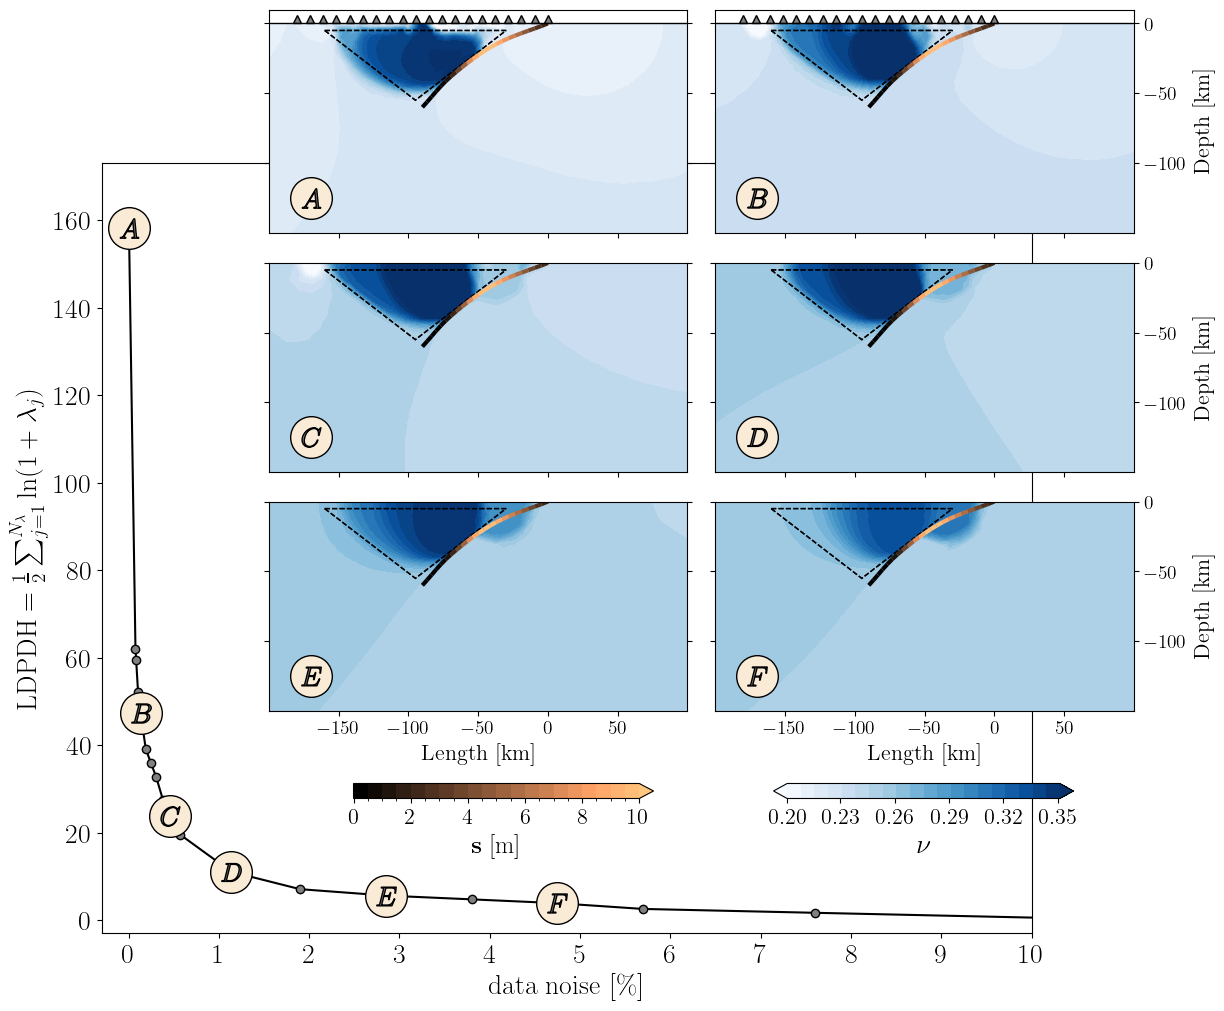

In [33]:
# Plot figure
fig, ax = plt.subplots(1, 1, figsize=(12,10))

choices = [0, 4, 9, 11, 13, 15]
colors = plt.cm.RdYlBu(np.linspace(0., 1., len(choices)))
L, W = 0.45, 0.5
XX = [0.18, 0.66]
YY = [0.805, 0.485, 0.175]
X = [XX[0], XX[1], XX[0], XX[1], XX[0], XX[1]]
Y = [YY[0], YY[0], YY[1], YY[1], YY[2], YY[2]]
markers = ['$A$', '$B$', '$C$', '$D$', '$E$', '$F$', '$G$', '$H$']
cmap_5 = plt.get_cmap("RdGy_r")

# Plot
ax.plot(noise/MAX_u*100, LDPDH, marker='o', ls='solid', color='black', mfc='gray', mec='k')
ax.set_xlabel(r'data noise [\%]')
ax.set_ylabel(r'$\mathrm{LDPDH} = \frac{1}{2}\sum_{j=1}^{N_\lambda} \ln(1 + \lambda_j)$')
ax.set_xlim((-0.3, 10.))
ax.set_ylim((-3, 173.))
ax.xaxis.set_ticks(np.arange(0, 11, 1.))

for i, j in enumerate(choices):
    
    ax.plot(noise[j]/MAX_u*100, LDPDH[j], marker='o', mfc='antiquewhite', mec='k', ms=30)
    ax.plot(noise[j]/MAX_u*100, LDPDH[j], marker=markers[i], mfc='gray', mec='k', ms=14)
    location = [X[i], Y[i], L, W]
    if i == 3:
        CS, line = plot_inset(mesh, ms[j], location, markers[i], label_left=True, label_bottom=False)
    elif i == 4:
        _, _ = plot_inset(mesh, ms[j], location, markers[i], label_left=False, label_bottom=True)
    elif i == 5:
        _, _ =plot_inset(mesh, ms[j], location, markers[i], label_left=True, label_bottom=True)
    elif i == 1:
        _, _ =plot_inset(mesh, ms[j], location, markers[i], label_left=True, label_bottom=False, triangles=True)
    elif i == 0:
        _, _ =plot_inset(mesh, ms[j], location, markers[i], label_left=False, label_bottom=False, triangles=True)
    else: 
        _, _ =plot_inset(mesh, ms[j], location, markers[i], label_left=False, label_bottom=False)

        
# Make a new Axes instance [left, bottom, width, height]
cbar_ax = plt.gcf().add_axes([0.685, 0.245, 0.25, 0.015])
cbar = plt.colorbar( CS, cax=cbar_ax, orientation="horizontal",
                    ticks=[0.2, 0.23, 0.26, 0.29, 0.32, 0.35],
                    format="%.2f", label=r'$\mathrm{\nu}$' )
#cbar.ax.set_xticklabels( ['0.2', '0.23', '0.26', '0.29', '0.32', '0.35'] )
cbar.ax.tick_params(labelsize=16)
cbar.ax.xaxis.set_ticks_position('bottom')
cbar.ax.xaxis.set_label_position('bottom')


# Make a new Axes instance [left, bottom, width, height]
cbar_ax2 = plt.gcf().add_axes([0.335, 0.245, 0.25, 0.015])
cbar2 = plt.colorbar( line, cax=cbar_ax2, orientation="horizontal",
                    ticks=[0., 2., 4., 6., 8., 10.],
                    format="%d" )
cbar2.set_label(label=r'$\mathbf{s}$ [m]', size=18)
cbar2.ax.tick_params(labelsize=16)
cbar2.ax.xaxis.set_ticks_position('bottom')
cbar2.ax.xaxis.set_label_position('bottom') 


plt.show()

In [36]:
# Save it as pandas dataframe
tosave = pd.DataFrame(lmbda_all.T, columns=['1.00e-04', '2.00e-03', '2.20e-03', '2.75e-03', '3.50e-03', 
                                            '5.00e-03', '6.50e-03', '8.00e-03', '1.00e-02', '1.20e-02', 
                                            '1.50e-02', '3.00e-02', '5.00e-02', '7.50e-02', '1.00e-01', 
                                            '1.25e-01', '1.50e-01', '2.00e-01', '3.00e-01'])

if False:
    savepath = "../Figures/"
    outFileName = 'eigenvalues_noise_mu_nu.txt'
    tosave.to_csv(savepath + outFileName, sep=' ', index=False)
